# Process Small Radar Doppler file to obtain velocity as a function of time

In [1]:
import scipy.io.wavfile
import scipy.constants
import pylab
import numpy as np
%matplotlib notebook

In [2]:
# read WAV file
fname = "fan.wav"
fc = 2428e6 # (Hz) Center frequency of VCO
rate,d = scipy.io.wavfile.read(fname)

In [3]:
# radar parameters
Tp = 0.5  # Time interval for each analysis block (Doppler analysis)
N = round(Tp*rate) # number of samples per pulse

In [4]:
print(N)

22050


In [5]:
# convert data into 2D array with column count = analysis block length
s = np.array(1*d[:,1],float) # the input appears to be inverted, so correct that
nblocks = len(s) // N
s = s[:nblocks*N] # keep integer number of pulses; ignore the fractional tail
s.shape = (-1,N)  # reshape

In [6]:
# subtract overall DC mean
s -= (s[:].mean())

In [7]:
# convert time to frequency
pad_factor = 16
S = np.fft.fft(s,int(N/2*pad_factor)) # pad with zeros for interpolated resolution
S = S[:,:int(S.shape[1]/2)] # only keep the positive half

In [8]:
# convert voltage to power and normalize by largest signal return
SL = 20*np.log10(abs(S))  # convert voltage to power
SL -= SL.max().max()      # largest signal return at 0 dB

In [9]:
# calculate velocity from frequency
delta_f = np.arange(SL.shape[1])*rate/SL.shape[1]  # standard frequency axis
wvlen = scipy.constants.c / fc  # wavelength
velocity = delta_f * wvlen / 2  # 2 since pulse goes there and back
vres = velocity[1] - velocity[0] # velocity resolution, m/s

In [10]:
# calculate time vector
tvec = np.arange(S.shape[0]) * Tp

In [11]:
# keep only those velocities we are going to plot
velocity_max = 40 # m/s
indx = np.where(velocity < velocity_max)[0]
velocity = velocity[indx]
SL = SL[:,indx]

<IPython.core.display.Javascript object>


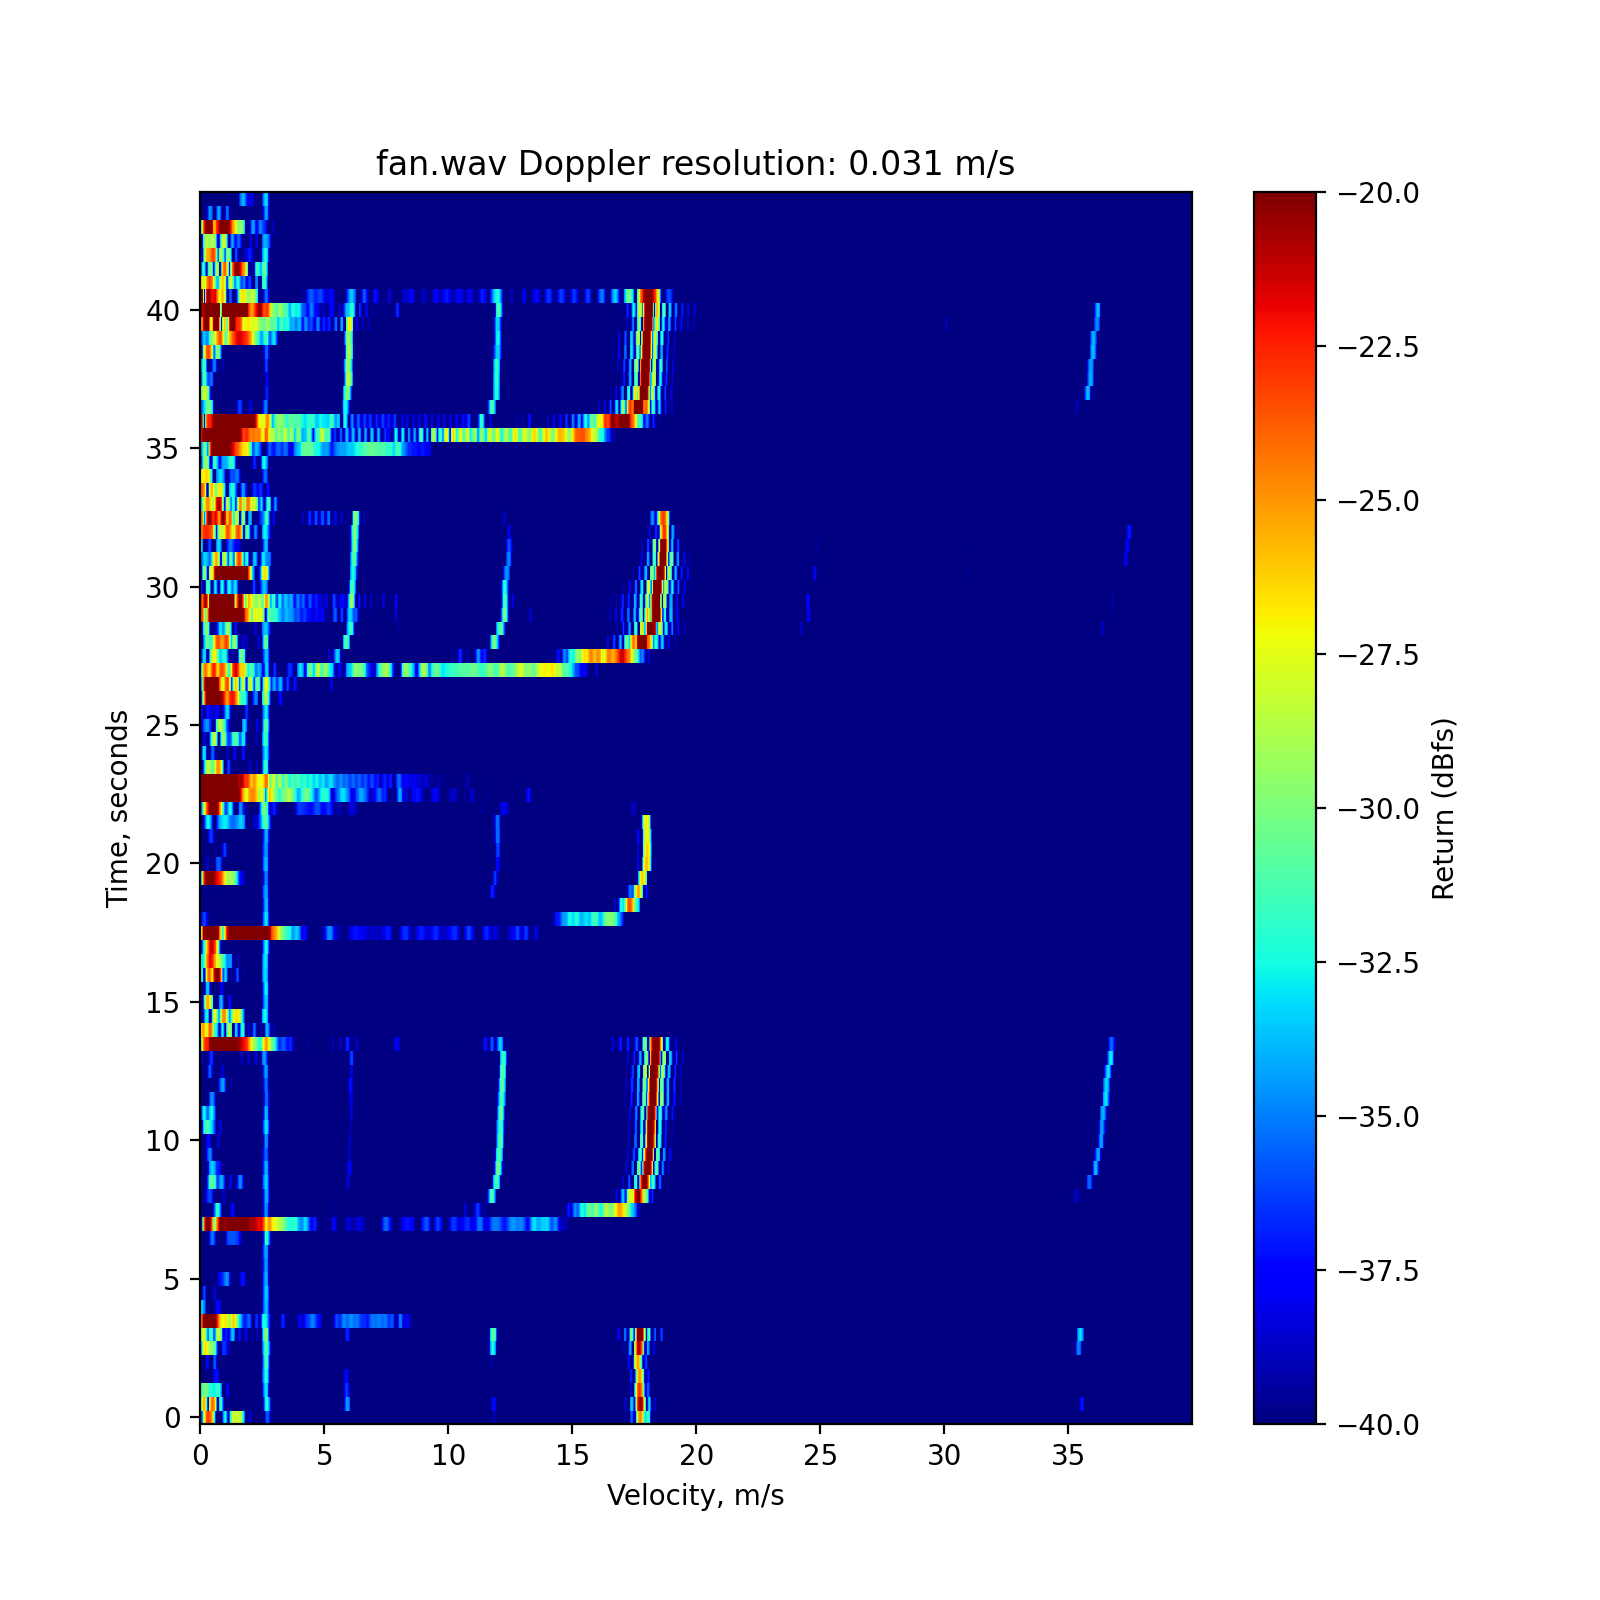

Text(0.5, 1.0, 'fan.wav Doppler resolution: 0.031 m/s')

In [12]:
# plot velocity tracks
f,ax = pylab.subplots(figsize=(8,8))
h = ax.pcolor(velocity, tvec, SL,vmin=-40,vmax=-20,cmap='jet')
f.colorbar(h,label='Return (dBfs)')
ax.set_ylabel('Time, seconds')
ax.set_xlabel('Velocity, m/s')
ax.set_title(fname + ' Doppler resolution: {:.3f} m/s'.format(vres))